# Random Ensemble Orchestration - With get STATE


## RL test

Defining the Simulation enviroment

In [6]:
from config_manager import ConfigManager
import logging
import os
import numpy as np
from state_manager import StateManager 
from visualization_manager import VisualizationManager, DashApp

import gym
from gym import spaces


class SimulationEnv(gym.Env):

    def __init__(self):
        super(SimulationEnv, self).__init__()

        current_dir = os.getcwd()   
        

        parent_dir = os.path.dirname(current_dir)
        CONFIG_PATH = os.path.join(current_dir, "sim_config.yaml")
        PROFILE_PATH = os.path.join(current_dir, "profile/model_profile/model_profile.yaml")


        self.state_manager = StateManager(current_dir)
        self.config_manager = ConfigManager(PROFILE_PATH, CONFIG_PATH)
        self.visualization_manager = VisualizationManager()
        self.dash_app = DashApp(self.visualization_manager)

        self.dash_app.run()

        # Define constants
        self.state_size = self.state_manager.state_lenght # Change this to be dynamic based on the enviroment
        # Observation space: Fixed size of 55
        self.observation_space = spaces.Box(
            low=0.0, high=10.0, shape=(self.state_size,), dtype=np.float32
        )

        # Action space (example: add/remove/replace a model)
        self.action_space = spaces.Discrete(3)

        self.weights = {
            "accuracy": 1.0,
            "confidence": 0.0,
            "latency": 0.0,
            "energy": 0.0,
            "explainability": 0.0
        }

    def reset(self):
        # Reset the environment to an initial state
        # Define Init Data:
        
        self.current_state = self.state_manager.get_state()  # Get initial state
        
        return self.state_manager.flatten_structured_state(self.current_state)

    def step(self, action):
        
        if action == 0:
            self.apply_action("keep_ensemble")
        elif action == 1:
            self.apply_action("add_model")
        elif action == 2:
            self.apply_action("replace_model")
      
        state = self.state_manager.get_state()
        print("STATE: ", state)

        # Simulate a step in the environment
        self.current_state = state
        reward = self._calculate_reward(self.current_state)
        self.visualization_manager.reward_list.append(reward)
        self.visualization_manager.flatten_state_to_csv(state)
        self.dash_app.update_graph()

        print("REWARD: ", reward)

        done = False  # Define termination condition if applicable
        
        return  self.state_manager.flatten_structured_state(self.current_state), reward, done, {}


    def _calculate_reward(self, state):
        model_states = state["model_states"]
        reward = 0.0
        
        metrics = model_states["ensemble"]
        
        reward += self.weights["accuracy"] * metrics["accuracy"]
        reward += self.weights["confidence"] * metrics["confidence"]

        return reward
    
    def apply_action(self, action):
    
        weights = self.weights
        manager = self.config_manager
        if action == "keep_ensemble":
            logging.info("Action: Keeping the ensemble")
        
        elif action == "add_model":
            manager.add_best_model(weights)
            logging.info("Action: Adding a model")
            # Logic for adding a new model (Placeholder)
        elif action == "replace_model":
            logging.info("Action: Replacing a model")
            manager.remove_worst_model(weights)
            manager.add_best_model(weights)
            # Logic for replacing a model (Placeholder)
        elif action == "remove_model":
            manager.remove_worst_model(weights)

        elif action == "add_random_model":
            manager.add_random_model()
        elif action == "remove_random_model":
            manager.remove_random_model()
        elif action == "replace_random_model":
            manager.remove_random_model()
            manager.add_random_model()


        else:
            logging.warning("Unknown action")

Running the simulation

In [7]:
from stable_baselines3 import PPO

#setup_config()

# Create the environment
env = SimulationEnv()

# Train the agent
model = PPO("MlpPolicy", env, verbose=1, n_steps=1028)
model.learn(total_timesteps=1)

# Save the trained model
model.save("simulation_policy")


Contents of initial_sim_config.yaml have been dumped into c:\Documents\Aalto Semester 2\ResearchCloud\RL_simulation\sim_config.yaml.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning:

You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1028`, after every 16 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1028 and n_envs=1)

2025-01-22 17:59:30,141:INFO -- Action: Adding a model


Best model: EfficientNetV2S with score: 0.953925925925926
Model 'EfficientNetV2S' successfully added to the target YAML.


2025-01-22 17:59:30,347:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.003833157044692698, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8364989558855692, 'avg_response_time': 2.05789025315367, 'max_response_time': 2.0769034695437374, 'contribution': 0.8364989558855692}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.38845465580622357, 'avg_response_time': 0.03660480847997461, 'max_response_time': 0.05765201932159984, 'contribution': 0.38845465580622357}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.6840378377172681, 'avg_response_time': 2.066981226335621, 'max_response_time': 2.0853497457787635, 'contribution': 0.9007989565531412}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8118118643760681, 'avg_response_time': 1.1114612382078328, 'max_res

2025-01-22 17:59:30,712:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006499981282645277, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8611472100019455, 'avg_response_time': 2.0544749933858126, 'max_response_time': 2.0769034695437374, 'contribution': 0.8611472100019455}, 'MobileNetV2': {'accuracy': 0.75, 'confidence': 0.4965403228998184, 'avg_response_time': 0.03840904206768121, 'max_response_time': 0.05765201932159984, 'contribution': 0.4965403228998184}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.7355900394419829, 'avg_response_time': 2.5032440670190637, 'max_response_time': 3.8120325890693914, 'contribution': 0.9093722105026245}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8704643845558167, 'avg_response_time': 1.1149154977619293, 'max_response_time': 

2025-01-22 17:59:30,929:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006499981282645277, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8679001927375793, 'avg_response_time': 2.055664484183559, 'max_response_time': 2.0769034695437374, 'contribution': 0.8679001927375793}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.7685760488112767, 'avg_response_time': 2.7694869379688702, 'max_response_time': 3.8344584217680953, 'contribution': 0.9110514283180237}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8849811355272929, 'avg_response_time': 1.1242510925357265, 'max_response_time': 1.

2025-01-22 17:59:31,307:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8711458841959635, 'avg_response_time': 2.0637379090649133, 'max_response_time': 2.1041050334716838, 'contribution': 0.8711458841959635}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.7793983312116728, 'avg_response_time': 3.501780512852014, 'max_response_time': 7.163248387267734, 'contribution': 0.910586396853129}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8908011615276337, 'avg_response_time': 1.1319825055168735, 'max_response_time': 1.155

2025-01-22 17:59:31,797:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8762111748967852, 'avg_response_time': 2.062103825128892, 'max_response_time': 2.1041050334716838, 'contribution': 0.8762111748967852}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.7963034631240935, 'avg_response_time': 4.01892522833844, 'max_response_time': 7.163248387267734, 'contribution': 0.9125582660947528}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8951128244400024, 'avg_response_time': 1.1323720298712867, 'max_response_time': 1.1551

2025-01-22 17:59:32,036:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01131999673746023, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8825253397226334, 'avg_response_time': 2.05906484802786, 'max_response_time': 2.1041050334716838, 'contribution': 0.8825253397226334}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8058441103746493, 'avg_response_time': 4.404895591747715, 'max_response_time': 7.163248387267734, 'contribution': 0.9228262230753899}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.889193038145701, 'avg_response_time': 1.1357416199244406, 'max_response_time': 1.15517

2025-01-22 17:59:32,283:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01131999673746023, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8905873762236701, 'avg_response_time': 2.057155310571496, 'max_response_time': 2.1041050334716838, 'contribution': 0.8905873762236701}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8149300761796809, 'avg_response_time': 4.706960609533446, 'max_response_time': 7.163248387267734, 'contribution': 0.92868705590566}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8883233325822013, 'avg_response_time': 1.138940230244016, 'max_response_time': 1.158131

2025-01-22 17:59:32,701:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01131999673746023, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.898164963722229, 'avg_response_time': 2.064925963408889, 'max_response_time': 2.1348618389454272, 'contribution': 0.898164963722229}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8262018145124117, 'avg_response_time': 4.947714570241686, 'max_response_time': 7.163248387267734, 'contribution': 0.9358178019523621}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8924220874905586, 'avg_response_time': 1.1438379225999054, 'max_response_time': 1.17812

2025-01-22 17:59:33,223:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01131999673746023, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.8986351327462629, 'avg_response_time': 2.0653038407161617, 'max_response_time': 2.1348618389454272, 'contribution': 0.8986351327462629}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.831554056387959, 'avg_response_time': 5.143790394235148, 'max_response_time': 7.163248387267734, 'contribution': 0.935301049189134}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8944343394703336, 'avg_response_time': 1.144958413797631, 'max_response_time': 1.17812

2025-01-22 17:59:33,627:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016804851811249164, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 1.0, 'confidence': 0.9026135951280594, 'avg_response_time': 2.0657460959147147, 'max_response_time': 2.1348618389454272, 'contribution': 0.9026135951280594}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8344226631025472, 'avg_response_time': 5.307089568315866, 'max_response_time': 7.163248387267734, 'contribution': 0.9406143029530843}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.8952954709529877, 'avg_response_time': 1.1434708412978303, 'max_response_time': 1.1

2025-01-22 17:59:34,082:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017675754738927185, 'ensemble_size': 7}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9230769230769231, 'confidence': 0.8331817801182086, 'avg_response_time': 2.064643816225062, 'max_response_time': 2.1348618389454272, 'contribution': 0.8331817801182086}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8399824639925589, 'avg_response_time': 5.4462886444033005, 'max_response_time': 7.163248387267734, 'contribution': 0.9398506742257339}, 'EfficientNetV2S': {'accuracy': 0.9090909090909091, 'confidence': 0.8139049735936251, 'avg_response_time': 1.143499633831

2025-01-22 17:59:34,484:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017825260597325844, 'ensemble_size': 8}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9285714285714286, 'confidence': 0.8363911168915885, 'avg_response_time': 2.0700806953516317, 'max_response_time': 2.140760123997036, 'contribution': 0.8363911168915885}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 1.0, 'confidence': 0.8318558526358434, 'avg_response_time': 5.569286855509271, 'max_response_time': 7.168263599886896, 'contribution': 0.9359590496335711}, 'EfficientNetV2S': {'accuracy': 0.9166666666666666, 'confidence': 0.8198602199554443, 'avg_response_time': 1.1448695444288

2025-01-22 17:59:35,349:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017825260597325844, 'ensemble_size': 8}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8666666666666667, 'confidence': 0.780631709098816, 'avg_response_time': 2.0711446454157176, 'max_response_time': 2.140760123997036, 'contribution': 0.8033115903536479}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9333333333333333, 'confidence': 0.7763987957934538, 'avg_response_time': 5.673939393535702, 'max_response_time': 7.168263599886896, 'contribution': 0.9260653614997864}, 'EfficientNetV2S': {'accuracy': 0.8461538461538461, 'confidence': 0.7567940491896409, 'avg_response_time': 1

2025-01-22 17:59:35,890:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.017859681623383035, 'ensemble_size': 9}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7898647598922253, 'avg_response_time': 2.071524576770625, 'max_response_time': 2.140760123997036, 'contribution': 0.8111271485686302}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9375, 'confidence': 0.7869166820361796, 'avg_response_time': 5.764930172161692, 'max_response_time': 7.168263599886896, 'contribution': 0.9306847117841244}, 'EfficientNetV2S': {'accuracy': 0.8571428571428571, 'confidence': 0.768589871270316, 'avg_response_time': 1.1472684902297268, 'max_re

2025-01-22 17:59:36,367:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018470515036970083, 'ensemble_size': 10}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8823529411764706, 'confidence': 0.7986050668884727, 'avg_response_time': 2.0739661710953423, 'max_response_time': 2.140760123997036, 'contribution': 0.8186167268192067}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9411764705882353, 'confidence': 0.7953031244572082, 'avg_response_time': 5.845371758944617, 'max_response_time': 7.168263599886896, 'contribution': 0.9346112924463609}, 'EfficientNetV2S': {'accuracy': 0.8666666666666667, 'confidence': 0.7769407550493876, 'avg_response_time':

2025-01-22 17:59:36,861:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018470515036970083, 'ensemble_size': 10}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.8080724312199487, 'avg_response_time': 2.0723644958665717, 'max_response_time': 2.140760123997036, 'contribution': 0.8269723322656419}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9444444444444444, 'confidence': 0.8038989466971453, 'avg_response_time': 5.914520941882841, 'max_response_time': 7.168263599886896, 'contribution': 0.9382320808039771}, 'EfficientNetV2S': {'accuracy': 0.875, 'confidence': 0.786455899477005, 'avg_response_time': 1.14639912270

2025-01-22 17:59:37,641:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018470515036970083, 'ensemble_size': 10}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8947368421052632, 'confidence': 0.8130466404714083, 'avg_response_time': 2.070354551430852, 'max_response_time': 2.140760123997036, 'contribution': 0.8309518098831177}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9473684210526315, 'confidence': 0.8102016056098087, 'avg_response_time': 5.979342160829934, 'max_response_time': 7.168263599886896, 'contribution': 0.9413665376211467}, 'EfficientNetV2S': {'accuracy': 0.8823529411764706, 'confidence': 0.7929106144344106, 'avg_response_time': 

2025-01-22 17:59:38,180:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9, 'confidence': 0.8184685945510864, 'avg_response_time': 2.0705457208690743, 'max_response_time': 2.140760123997036, 'contribution': 0.8354785054922104}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.95, 'confidence': 0.8138747760491689, 'avg_response_time': 6.036200833895274, 'max_response_time': 7.168263599886896, 'contribution': 0.9438441246747971}, 'EfficientNetV2S': {'accuracy': 0.8888888888888888, 'confidence': 0.798742436700397, 'avg_response_time': 1.1473776490006822, 'max_resp

2025-01-22 17:59:39,008:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018556997220561713, 'ensemble_size': 11}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.9047619047619048, 'confidence': 0.8237230068161374, 'avg_response_time': 2.069851212642574, 'max_response_time': 2.140760123997036, 'contribution': 0.8399229219981602}, 'MobileNetV2': {'accuracy': 0.8, 'confidence': 0.5807859182357789, 'avg_response_time': 0.04030498876340015, 'max_response_time': 0.05765201932159984, 'contribution': 0.5807859182357789}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9523809523809523, 'confidence': 0.817981982447956, 'avg_response_time': 6.088471731232808, 'max_response_time': 7.168263599886896, 'contribution': 0.9462054598899114}, 'EfficientNetV2S': {'accuracy': 0.8947368421052632, 'confidence': 0.8034103826472634, 'avg_response_time': 1

2025-01-22 17:59:39,682:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018591318869234208, 'ensemble_size': 12}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8636363636363636, 'confidence': 0.7862810519608584, 'avg_response_time': 2.0710850722343257, 'max_response_time': 2.140760123997036, 'contribution': 0.8017446073618802}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.48398826519648236, 'avg_response_time': 0.04956355427721825, 'max_response_time': 0.09585638184630875, 'contribution': 0.48398826519648236}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9545454545454546, 'confidence': 0.8123688426245042, 'avg_response_time': 6.134209809535364, 'max_response_time': 7.168263599886896, 'contribution': 0.9361676953055642}, 'EfficientNetV2S': {'accuracy': 0.9, 'confidence': 0.7995085954666138, 'avg_response_time

2025-01-22 17:59:40,274:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018654365737329086, 'ensemble_size': 13}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8695652173913043, 'confidence': 0.7913709671601005, 'avg_response_time': 2.071574210245325, 'max_response_time': 2.140760123997036, 'contribution': 0.8061621940654257}, 'MobileNetV2': {'accuracy': 0.5714285714285714, 'confidence': 0.4148470844541277, 'avg_response_time': 0.05596533342611177, 'max_response_time': 0.09585638184630875, 'contribution': 0.4148470844541277}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9565217391304348, 'confidence': 0.8157725523599391, 'avg_response_time': 6.178858246520573, 'max_response_time': 7.168263599886896, 'contribution': 0.9357642842375714}, 'EfficientNetV2S': {'accuracy': 0.9047619047619048, 'confidence': 0.8048120708692641, 'avg_r

2025-01-22 17:59:41,017:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.018654365737329086, 'ensemble_size': 13}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.875, 'confidence': 0.7966488301753998, 'avg_response_time': 2.0688953735298985, 'max_response_time': 2.140760123997036, 'contribution': 0.8108237559596697}, 'MobileNetV2': {'accuracy': 0.625, 'confidence': 0.46131496876478195, 'avg_response_time': 0.06257476402318492, 'max_response_time': 0.10884077820269697, 'contribution': 0.46131496876478195}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9583333333333334, 'confidence': 0.8209978947705161, 'avg_response_time': 6.219040085016679, 'max_response_time': 7.168263599886896, 'contribution': 0.9384399230281512}, 'EfficientNetV2S': {'accuracy': 0.9090909090909091, 'confidence': 0.8095797788013112, 'avg_response_time': 1.149051

2025-01-22 17:59:41,656:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.88, 'confidence': 0.8021299481391907, 'avg_response_time': 2.0684926527844554, 'max_response_time': 2.140760123997036, 'contribution': 0.8157378768920899}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.515729824701945, 'avg_response_time': 0.06555019974484746, 'max_response_time': 0.10884077820269697, 'contribution': 0.515729824701945}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.96, 'confidence': 0.82377298942463, 'avg_response_time': 6.255583806121645, 'max_response_time': 7.168263599886896, 'contribution': 0.940839307308197}, 'EfficientNetV2S': {'accuracy': 0.9130434782608695, 'confidence': 0.8141572553178539, 'avg_response_time': 1.1485804726472362

2025-01-22 17:59:42,305:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8846153846153846, 'confidence': 0.806798905134201, 'avg_response_time': 2.069771233533629, 'max_response_time': 2.140760123997036, 'contribution': 0.8198834520119888}, 'MobileNetV2': {'accuracy': 0.7, 'confidence': 0.5509335398674011, 'avg_response_time': 0.06798392834801023, 'max_response_time': 0.10884077820269697, 'contribution': 0.5509335398674011}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9615384615384616, 'confidence': 0.8248306942657384, 'avg_response_time': 6.289292151727251, 'max_response_time': 7.168263599886896, 'contribution': 0.9425979462953714}, 'EfficientNetV2S': {'accuracy': 0.9166666666666666, 'confidence': 0.8168457647164663, 'avg_response_time': 1.

2025-01-22 17:59:42,960:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8888888888888888, 'confidence': 0.8115227906792252, 'avg_response_time': 2.069776390659124, 'max_response_time': 2.140760123997036, 'contribution': 0.8241227247096874}, 'MobileNetV2': {'accuracy': 0.7272727272727273, 'confidence': 0.5761082605882124, 'avg_response_time': 0.07018276716894435, 'max_response_time': 0.10884077820269697, 'contribution': 0.5761082605882124}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9629629629629629, 'confidence': 0.8283375770468491, 'avg_response_time': 6.318916548310197, 'max_response_time': 7.168263599886896, 'contribution': 0.9447235420898155}, 'EfficientNetV2S': {'accuracy': 0.92, 'confidence': 0.8206985664367675, 'avg_response_time': 

2025-01-22 17:59:43,816:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01894598299398171, 'ensemble_size': 14}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8928571428571429, 'confidence': 0.8167536216122764, 'avg_response_time': 2.069949928339541, 'max_response_time': 2.140760123997036, 'contribution': 0.8289035579987934}, 'MobileNetV2': {'accuracy': 0.75, 'confidence': 0.5684767713149389, 'avg_response_time': 0.071887797473266, 'max_response_time': 0.10884077820269697, 'contribution': 0.5684767713149389}, 'ResNet50V2': {'accuracy': 1.0, 'confidence': 0.5565559466679891, 'avg_response_time': 0.11347026663042319, 'max_response_time': 0.12229664638153938, 'contribution': 0.5565559466679891}, 'ensemble': {'accuracy': 0.9642857142857143, 'confidence': 0.8287157492179303, 'avg_response_time': 6.3483617473997525, 'max_response_time': 7.168263599886896, 'contribution': 0.9463158952338355}, 'EfficientNetV2S': {'accuracy': 0.9230769230769231, 'confidence': 0.8238751131754655, 'avg_response_time': 1

KeyboardInterrupt: 

# Check results

In [8]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = "results/reinf_learning_inference/ensemble_inference.csv"

print("action policy: random action - with Bounds\n")
# Read the CSV file
df = pd.read_csv(csv_file_path)
print("number of inferences: ", df.size)

# Calculate average accuracy for all labels
average_accuracy_all = df["accuracy"].mean()

# Calculate average accuracy for a specific label
average_accuracy_per_label = df.groupby("label")["accuracy"].mean()

# Print the results
print(f"Average accuracy across all labels: {average_accuracy_all:.4f}")
print(f"Average accuracy for all labels: ") 
print(average_accuracy_per_label)

action policy: random action - with Bounds

number of inferences:  145
Average accuracy across all labels: 0.9655
Average accuracy for all labels: 
label
n01440764    1.000
n01443537    1.000
n01484850    1.000
n01491361    0.875
n01494475    1.000
Name: accuracy, dtype: float64


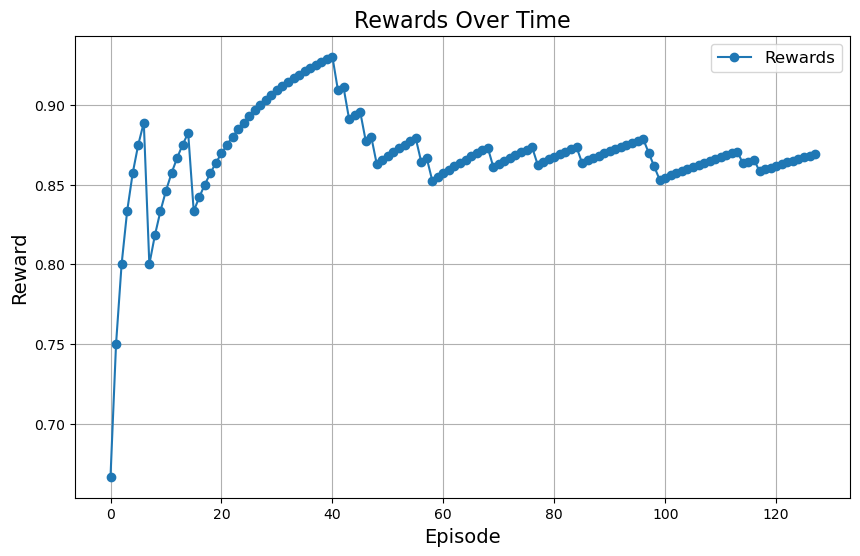

In [3]:

import matplotlib.pyplot as plt

# Assuming env.visualization_manager.reward_list is a list of rewards
def plot_rewards(reward_list):
    plt.figure(figsize=(10, 6))
    plt.plot(reward_list, label="Rewards", marker='o', linestyle='-')
    plt.title("Rewards Over Time", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

# Example usage:
if hasattr(env, 'visualization_manager') and hasattr(env.visualization_manager, 'reward_list'):
    plot_rewards(env.visualization_manager.reward_list)
else:
    print("reward_list not found in env.visualization_manager.")